In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2022-12-02 09:09:29.267575: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-02 09:09:29.270350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 09:09:29.270358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


In [2]:
import  pathlib

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [5]:
data_dir = tf.keras.utils.get_file(origin=url,
                            fname="flower_photos",
                            untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 52s 0us/step


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


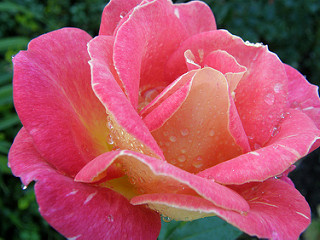

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility
`tf.keras.utils.image_dataset_from_directory `

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      validation_split=0.2,
                                                      subset='training',
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-12-02 09:18:51.852313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 09:18:51.852328: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 09:18:51.852337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-12-02 09:18:51.852513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    seed=123,
                                                    image_size=(img_height, img_width),
                                                    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

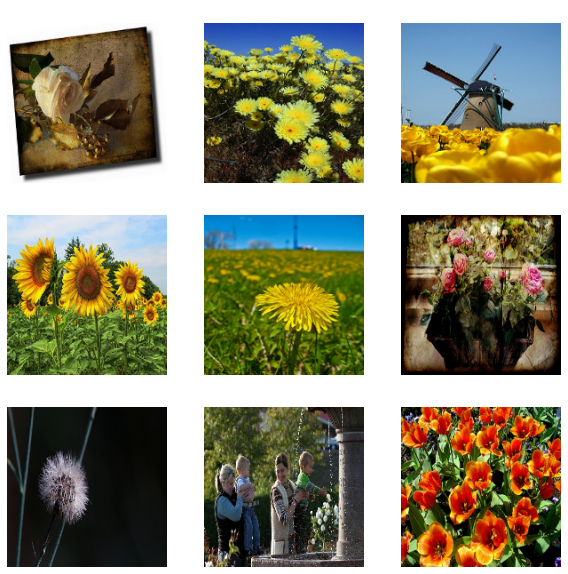

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]], color='white')
        plt.axis('off')

In [16]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
layer = tf.keras.layers

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train


The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). 

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    normalization_layer,
    layer.Conv2D(32, 3, activation='relu'),
    layer.MaxPooling2D(),
    layer.Conv2D(32, 3, activation='relu'),
    layer.MaxPooling2D(),
    layer.Conv2D(32, 3, activation='relu'),
    layer.MaxPooling2D(),
    layer.Flatten(),
    layer.Dense(128, activation='relu'),
    layer.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [24]:
model.fit(train_ds,
         validation_data=val_ds,
         epochs=10
         )

Epoch 1/10
92/92 [==============================] - 12s 122ms/step - loss: 1.3150 - accuracy: 0.4319 - val_loss: 1.1667 - val_accuracy: 0.5095
Epoch 2/10
92/92 [==============================] - 11s 120ms/step - loss: 1.0218 - accuracy: 0.6018 - val_loss: 0.9471 - val_accuracy: 0.6322
Epoch 3/10
92/92 [==============================] - 12s 126ms/step - loss: 0.8486 - accuracy: 0.6792 - val_loss: 0.9773 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 12s 129ms/step - loss: 0.7014 - accuracy: 0.7296 - val_loss: 0.9755 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 12s 129ms/step - loss: 0.5198 - accuracy: 0.7987 - val_loss: 1.0140 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 12s 129ms/step - loss: 0.3647 - accuracy: 0.8678 - val_loss: 1.1669 - val_accuracy: 0.6349
Epoch 7/10
92/92 [==============================] - 12s 128ms/step - loss: 0.2179 - accuracy: 0.9268 - val_loss: 1.3442 - val_accuracy: 0.6431

Overfitting

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

In [26]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [27]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/nsl54/.keras/datasets/flower_photos/dandelion/8740787470_67230d0609.jpg'
b'/home/nsl54/.keras/datasets/flower_photos/daisy/5434914569_e9b982fde0_n.jpg'
b'/home/nsl54/.keras/datasets/flower_photos/dandelion/8979087213_28f572174c.jpg'
b'/home/nsl54/.keras/datasets/flower_photos/roses/9159362388_c6f4cf3812_n.jpg'
b'/home/nsl54/.keras/datasets/flower_photos/daisy/14569895116_32f0dcb0f9.jpg'


##### The tree structure of the files can be used to compile a `class_names` list.

In [28]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [29]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [30]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


#### A short function that converts a file path to an (img, label) pair:

In [31]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [32]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    
    return tf.image.resize(img, [img_height, img_width])

In [33]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### Create a dataset of image, label pairs

In [37]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [38]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


2022-12-02 12:49:29.907010: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Configure dataset for performance

To train a model with this dataset:
- shuffle the dataset
- batch the dataset
- batches should be available as soon as possible

These features can be added using the tf.data API